In [1]:
import pandas as pd 
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.decomposition import PCA
import numpy as np
from sklearn.model_selection import train_test_split

In [30]:
d1 = pd.read_csv('P1.csv', sep=',')
d2 = pd.read_csv('P2.csv', sep=',')
d1 = d1.drop(labels=['DY', 'LAT' ,'LON', 'MO', 'YEAR'], axis=1)
df= pd.concat([d1, d2], axis=1, join_axes=[d1.index])
print(df.shape)
df = df[df['PRECTOT'] != -9.990e+02]
df = df[df['ALLSKY_SFC_SW_DWN'] != -999.0]
df = df[df['CLRSKY_SFC_SW_DWN'] != -999.0]
df = df[df['KT'] != -999.0]
df = df[df['KT_CLEAR'] != -999.0]
print(df.shape)

(1096, 22)
(294, 22)


In [31]:
train_labs = ['DY' ,'KT',
             'KT_CLEAR', 'LAT' ,'LON' ,'MO', 'PRECTOT', 'PS', 
              'QV2M', 'RH2M', 'T2M', 'T2MDEW',
             'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 
              'TS', 'WS10M', 'WS50M', 'YEAR']
usef_df = df[[*train_labs, 'ALLSKY_SFC_SW_DWN',
              'ALLSKY_SFC_LW_DWN', 'CLRSKY_SFC_SW_DWN']]

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler(copy=True, with_mean=True, with_std=False)
# X_train = scaler.fit_transform(X_train)
# y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
# X_test = scaler.fit_transform(X_test)
# y_test = scaler.fit_transform(y_test.values.reshape(-1, 1))
# pca = PCA(n_components=8)
# X_train = pca.fit_transform(X_train)
# X_test = pca.fit_transform(X_test)


# print(pca.explained_variance_)
# print(pca.explained_variance_ratio_)
# print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

In [32]:
clfs = [
    GradientBoostingRegressor(n_estimators=200),
    GradientBoostingRegressor(n_estimators=200, loss='lad'),
    GradientBoostingRegressor(n_estimators=200, criterion='mae'),
    GradientBoostingRegressor(n_estimators=200, loss='huber', alpha=0.2),
    GradientBoostingRegressor(n_estimators=600, loss='huber', alpha=0.3, tol=1e-7),
    GradientBoostingRegressor(n_estimators=500, loss='huber', alpha=0.85),
]
for clf in clfs:
    clf.fit(X_train, y_train)
    print(clf.score(X_test, y_test))

0.9372085921195681
0.9301639144736683
0.9234153578343799
0.916536691293305
0.9123016738022129
0.9331980956470933


In [92]:
import_df = pd.DataFrame()
for lab in ['ALLSKY_SFC_SW_DWN',
              'ALLSKY_SFC_LW_DWN', 'CLRSKY_SFC_SW_DWN']:
    X_train, X_test, y_train, y_test = train_test_split(usef_df[train_labs],
                                                        usef_df[lab], 
                                                        test_size=0.3, 
                                                        random_state=0)
    tst_clf =  GradientBoostingRegressor(n_estimators=200, loss='huber')
    tst_clf.fit(X_train, y_train)
    scr = tst_clf.score(X_test, y_test)
    print(scr)
    tmp = pd.DataFrame({'feature': train_labs, 
                              'importance': tst_clf.feature_importances_,
                               'index': [lab for i in range(len(train_labs))],
                               'score': [scr for i in range(len(train_labs))]})
#     tmp.set_index('index')
    import_df = import_df.append(tmp)
# import_df.set_index('index', inplace=True)
print(import_df.head())
import_df = import_df[import_df['importance'] >= 0.05]
import_df['score'] *= 100
import_df['score'] = import_df['score'].astype(np.int)

0.9584422224837613
0.9645236085209973
0.937647600217071
    feature  importance              index     score
0        DY    0.004072  ALLSKY_SFC_SW_DWN  0.958442
1        KT    0.042664  ALLSKY_SFC_SW_DWN  0.958442
2  KT_CLEAR    0.034570  ALLSKY_SFC_SW_DWN  0.958442
3       LAT    0.000000  ALLSKY_SFC_SW_DWN  0.958442
4       LON    0.000000  ALLSKY_SFC_SW_DWN  0.958442


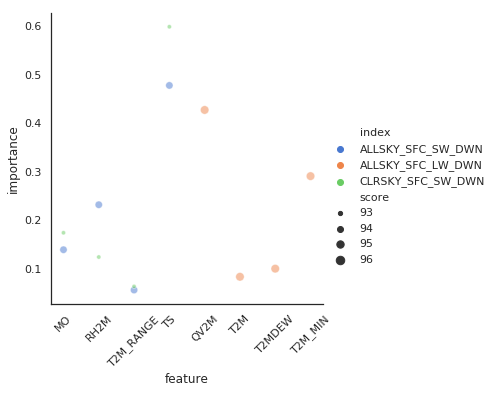

In [93]:
sns.set(style="white")

g = sns.relplot(x="feature", y="importance", hue="index", size='score',
            data=import_df, palette='muted', alpha=0.5);
g.set_xticklabels(rotation=45)

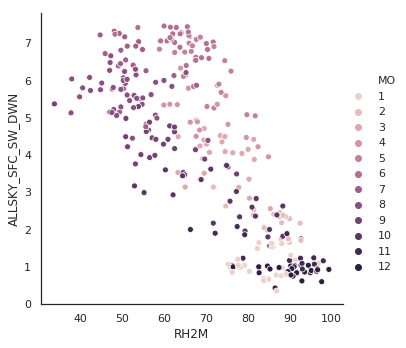

In [110]:
ax = sns.relplot(x='RH2M', y='ALLSKY_SFC_SW_DWN', hue='MO',
                  legend='full', data=usef_df)

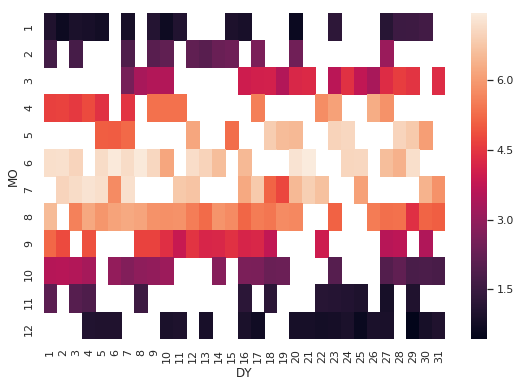

In [123]:
# Draw a heatmap with the numeric values in each cell
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(9, 6))
pivoted = pd.pivot_table(usef_df,
                        values='ALLSKY_SFC_SW_DWN',
                        index=['MO'], columns='DY')
sns.heatmap(pivoted, annot=False)